📦 Cellule 1 – Imports & configuration

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import logging
from tabulate import tabulate
import numpy as np
from matplotlib_scalebar.scalebar import ScaleBar

logging.basicConfig(level=logging.INFO)
PROVINCE_FILE = "data1/provinces.geojson"
PARK_FILE = "data1/protected_zones.geojson"

provinces = gpd.read_file(PROVINCE_FILE)
park = gpd.read_file(PARK_FILE)
park = park.to_crs(provinces.crs)
logging.info("Data loaded")

🧩 Cellule 2 – Jointure spatiale (intersects)

In [ ]:
park_province = gpd.sjoin(
    park,
    
    provinces,
    how="left",
    predicate="intersects"
)

logging.info("Spatial join performed (intersects)")


📋 Cellule 3 – Affichage parc → province

In [ ]:
logging.info("Each park and its province")
logging.info(
    "\n%s",
    tabulate(
        park_province[["NOM_left", "NOM_right"]],
        headers=["PARK", "PROVINCE"],
        tablefmt="grid",
        showindex=False
    )
)

🌍 Cellule 4 – Parcs s’étendant sur plusieurs provinces

In [ ]:
park_multi_provinces = (
    park_province
    .groupby("NOM_left")
    .agg(
        COUNT_PROVINCES=("NOM_right", "nunique"),
        PROVINCES=("NOM_right", lambda x: ", ".join(sorted(x.unique())))
    )
    .reset_index()
)

park_multi_provinces = park_multi_provinces[
    park_multi_provinces["COUNT_PROVINCES"] > 1
]

logging.info("--- Parks spanning multiple provinces ---")
logging.info(
    "\n%s",
    tabulate(
        park_multi_provinces,
        headers=["PARK", "COUNT_PROVINCES", "PROVINCES"],
        tablefmt="grid",
        showindex=False
    )
)

🗺️ Cellule 5 – Carte des parcs multi-provinces

In [ ]:
park_visu = park[
    park["NOM"].isin(park_multi_provinces["NOM_left"])
]

fig, ax = plt.subplots(figsize=(10, 10))
provinces.plot(ax=ax, color="lightgrey", edgecolor="black")
park_visu.plot(ax=ax, column="NOM", legend=True)

leg = ax.get_legend()
leg.set_bbox_to_anchor((1.02, 1))
leg.set_loc("upper left")

plt.title("Parks extending across more than two provinces")
plt.tight_layout()
plt.show()

🏞️ Cellule 6 – Parcs entièrement contenus dans une province

In [ ]:
park_within_prov = gpd.sjoin(
    park,
    provinces,
    how="inner",
    predicate="within"
)

logging.info("Parks entirely contained within a province")
logging.info(
    "\n%s",
    tabulate(
        park_within_prov[["NOM_left", "NOM_right"]],
        headers=["PARK", "PROVINCE"],
        tablefmt="grid",
        showindex=False
    )
)

✍️ Cellule 7 – Carte + noms des parcs

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
provinces.plot(ax=ax, color="white", edgecolor="black")
park_within_prov.plot(ax=ax, color="green")

for _, row in park_within_prov.iterrows():
    x, y = row.geometry.centroid.x, row.geometry.centroid.y
    ax.text(
        x, y,
        row["NOM_left"],
        fontsize=9,
        ha="center",
        va="center",
        bbox=dict(facecolor="white", alpha=0.5, edgecolor="none")
    )

plt.title("Parks entirely contained within a province")
plt.show()

📊 Cellule 8 – Nombre de parcs par province

In [ ]:
nb_parcs_province = (
    park_province
    .groupby("NOM_right")
    .agg(
        COUNT_PARKS=("NOM_left", "nunique"),
        PARKS=("NOM_left", lambda x: "\n".join(sorted(x.unique())))
    )
    .reset_index()
)

logging.info("Number of parks per province")
logging.info(
    "\n%s",
    tabulate(
        nb_parcs_province[["NOM_right", "COUNT_PARKS"]],
        headers=["PROVINCE", "COUNT_PARKS"],
        tablefmt="grid",
        showindex=False
    )
)


📈 Cellule 9 – Histogramme

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(
    nb_parcs_province["NOM_right"],
    nb_parcs_province["COUNT_PARKS"]
)

ax.set_title("Number of parks per province")
ax.set_xlabel("Province")
ax.set_ylabel("Number of parks")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


🚫 Cellule 10 – Provinces sans parc

In [ ]:
provinces_without_park = provinces[
    ~provinces["NOM"].isin(nb_parcs_province["NOM_right"])
]

logging.info("--- Provinces without a national park ---")
logging.info(
    "\n%s",
    tabulate(
        provinces_without_park[["NOM"]],
        headers=["PROVINCE"],
        tablefmt="grid",
        showindex=False
    )
)


📐 Cellule 11 – Superficie des parcs par province

In [ ]:
park_province["surface_km2"] = park_province.geometry.area / 1_000_000

surface_parc_province = (
    park_province
    .groupby(["NOM_left", "NOM_right"])["surface_km2"]
    .sum()
    .reset_index()
)

logging.info("Area of each park by province")
logging.info(
    "\n%s",
    tabulate(
        surface_parc_province,
        headers=["PARK", "PROVINCE", "AREA_KM2"],
        tablefmt="grid",
        showindex=False
    )
)


🧭 Cellule 12 – Carte finale (contenus vs multi-provinces)

C:\Users\Stagiaire Drone\AppData\Local\Temp\ipykernel_11436\2480268164.py:93: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc="upper right")
C:\Users\Stagiaire Drone\AppData\Local\Temp\ipykernel_11436\2480268164.py:93: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")


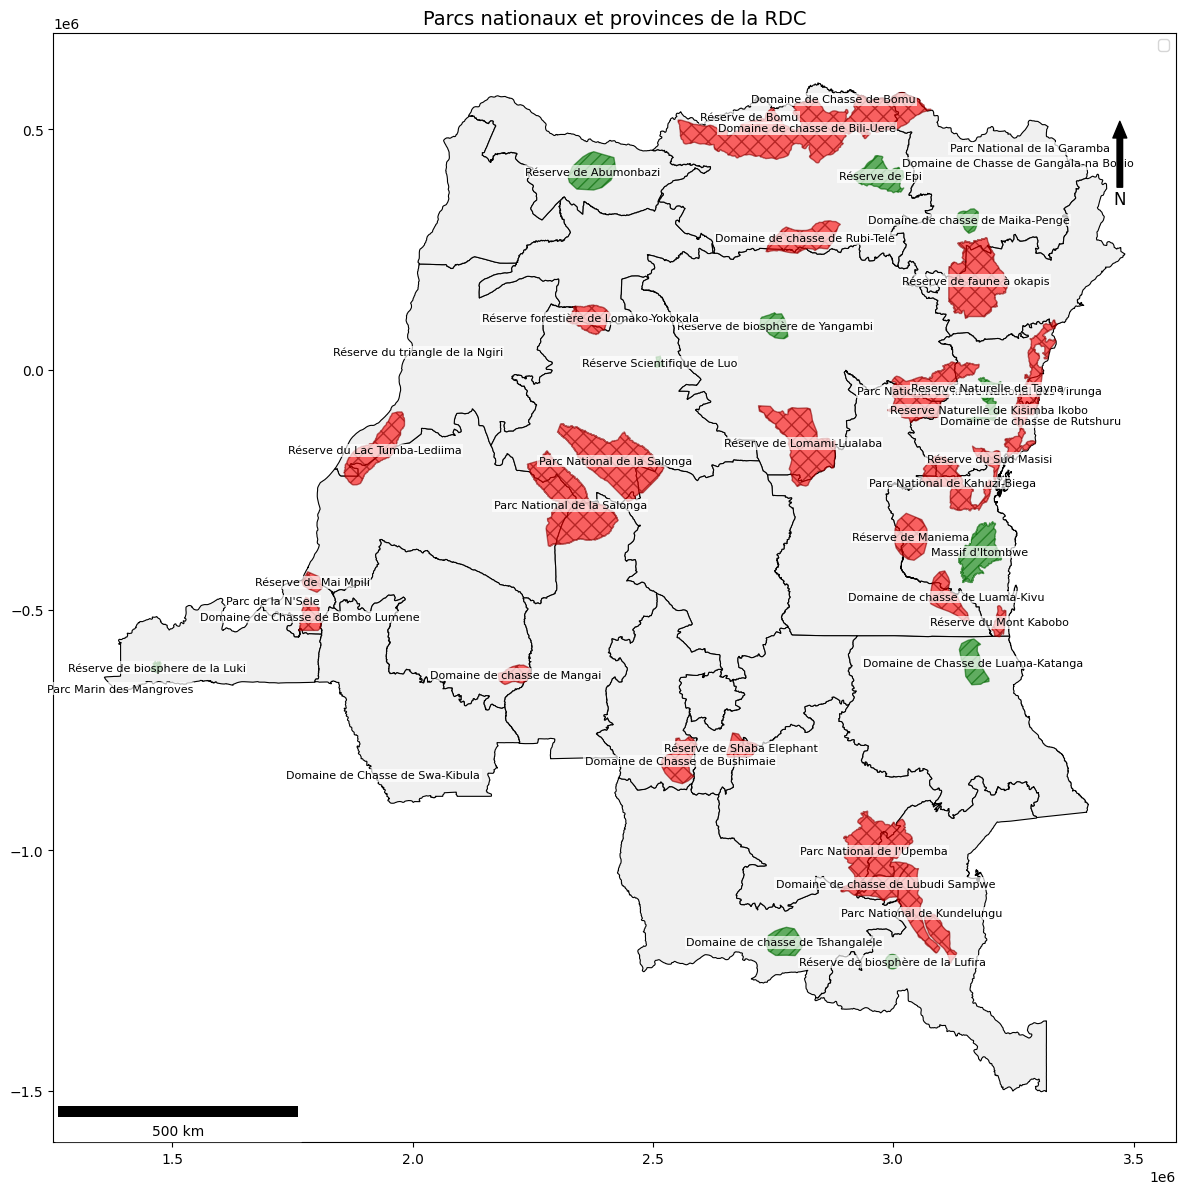

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))

# all provinces
provinces.plot(
    ax=ax,
    color="#f0f0f0",
    edgecolor="black",
    linewidth=0.8
)
# park within province
park_within_prov.plot(
    ax=ax,
    color="green",
    alpha=0.6,
    hatch="///",
    edgecolor="darkgreen",
    label="Parcs contenus"
)

# park multi-provinces
parcs_multi_geom = park[
    park["NOM"].isin(park_multi_provinces["NOM_left"])
]

parcs_multi_geom.plot(
    ax=ax,
    color="red",
    alpha=0.6,
    hatch="xx",
    edgecolor="darkred",
    label="Parcs multi-provinces"
)

offsets = np.linspace(-0.02, 0.02, len(park))

for i, (_, row) in enumerate(park.iterrows()):
    centroid = row.geometry.centroid
    ax.text(
        centroid.x + offsets[i],
        centroid.y + offsets[::-1][i],
        row["NOM"],
        fontsize=8,
        ha="center",
        va="center",
        bbox=dict(
            facecolor="white",
            alpha=0.7,
            edgecolor="none",
            pad=1
        )
    )

# North arrow
ax.annotate(
    "N",
    xy=(0.95, 0.92),
    xytext=(0.95, 0.85),
    arrowprops=dict(facecolor="black", width=4, headwidth=10),
    ha="center",
    va="center",
    fontsize=12,
    xycoords=ax.transAxes
)
# Scale bar (km)
scalebar = ScaleBar(
    dx=1,
    units="m",
    dimension="si-length",
    location="lower left",
    length_fraction=0.25
)
ax.add_artist(scalebar)

plt.legend(loc="upper right")
plt.title("Parcs nationaux et provinces de la RDC", fontsize=14)
plt.tight_layout()
plt.show()
